In [1]:
# Import statement
import xarray as xr
from typing import List
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


# Set default style to dark background because I like it better
plt.style.use("dark_background")
plt.rcParams["hatch.linewidth"] = 0.4


In [2]:
# Define useful functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def smooth(da: xr.DataArray, sigma: int = 3, axes: tuple = (1, 2)) -> xr.DataArray:
    """Apply Gaussian smoothing to the DataArray."""
    smoothed_da = da.copy()
    smoothed_da.values = gaussian_filter(da.values, sigma=sigma, axes=axes)
    smoothed_da = smoothed_da.assign_attrs(da.attrs)
    return smoothed_da


def get_mean_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the mean of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Mean variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).mean(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})


def get_total_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the sum of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).sum(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})


def get_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Return a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [w[varname].sel(time=slice(start_time, end_time)) for w in wofs_list],
        dim=init_dim,
    ).chunk({"init": -1})


def calc_ens_sens(predictor: xr.DataArray, predictand: xr.DataArray) -> xr.DataArray:
    """
    Calculate the ensemble sensitivity of the predictand to the predictor.

    Parameters:
    predictor (xr.DataArray): DataArray housing the predictor.
    predictand (xr.DataArray): DataArray containing the predictand

    Returns:
    xr.DataArray: The ensemble sensitivity.
    """

    # Calculate the covariance
    covar = (
        (predictor - predictor.mean(dim=("init", "ne")))
        * (predictand - predictand.mean(dim=("init", "ne")))
    ).mean(dim=("init", "ne"))

    # predictor_var = ((predictor - predictor.mean(dim=("init", "ne"))) ** 2).mean(
    #     dim=("init", "ne")
    # )

    predictor_var = predictor.std(dim=("init","ne")) ** 2
    
    # Calculate sensitivity
    sens = covar / predictor_var

    return sens

    


In [3]:
# Load in 20-01Z initializations
wofs_all = [get_wofs_all(i) for i in [20,21,22,23,0,1]]

In [4]:
# Define variables and parameters
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Create a DataArray for the initialization dimension
init = xr.DataArray(
    data=["20Z", "21Z", "22Z", "23Z", "00Z", "01Z"], dims="init"
).assign_coords({"init": ["20Z", "21Z", "22Z", "23Z", "00Z", "01Z"]})


In [5]:
# Get the 01 to 02 UTC rainfall
rain12 = get_total_field(
    wofs_all, "rain", "2021-09-02 01:05:00", "2021-09-02 02:00:00", init_dim=init
)
# rain01 = get_total_field(wofs_all, "rain", "2021-09-02 00:05:00", "2021-09-02 01:00:00", init_dim=init)

# Calculate standard deviation of rainfall
std = rain12.std(dim=("init", "ne"))

# Lastly, make our area of interest where sd > 65% of max sd
aoi = std > (std.max() * 0.65)

rain12_aoi = rain12.where(aoi).mean(dim=("lat", "lon"), skipna=True)


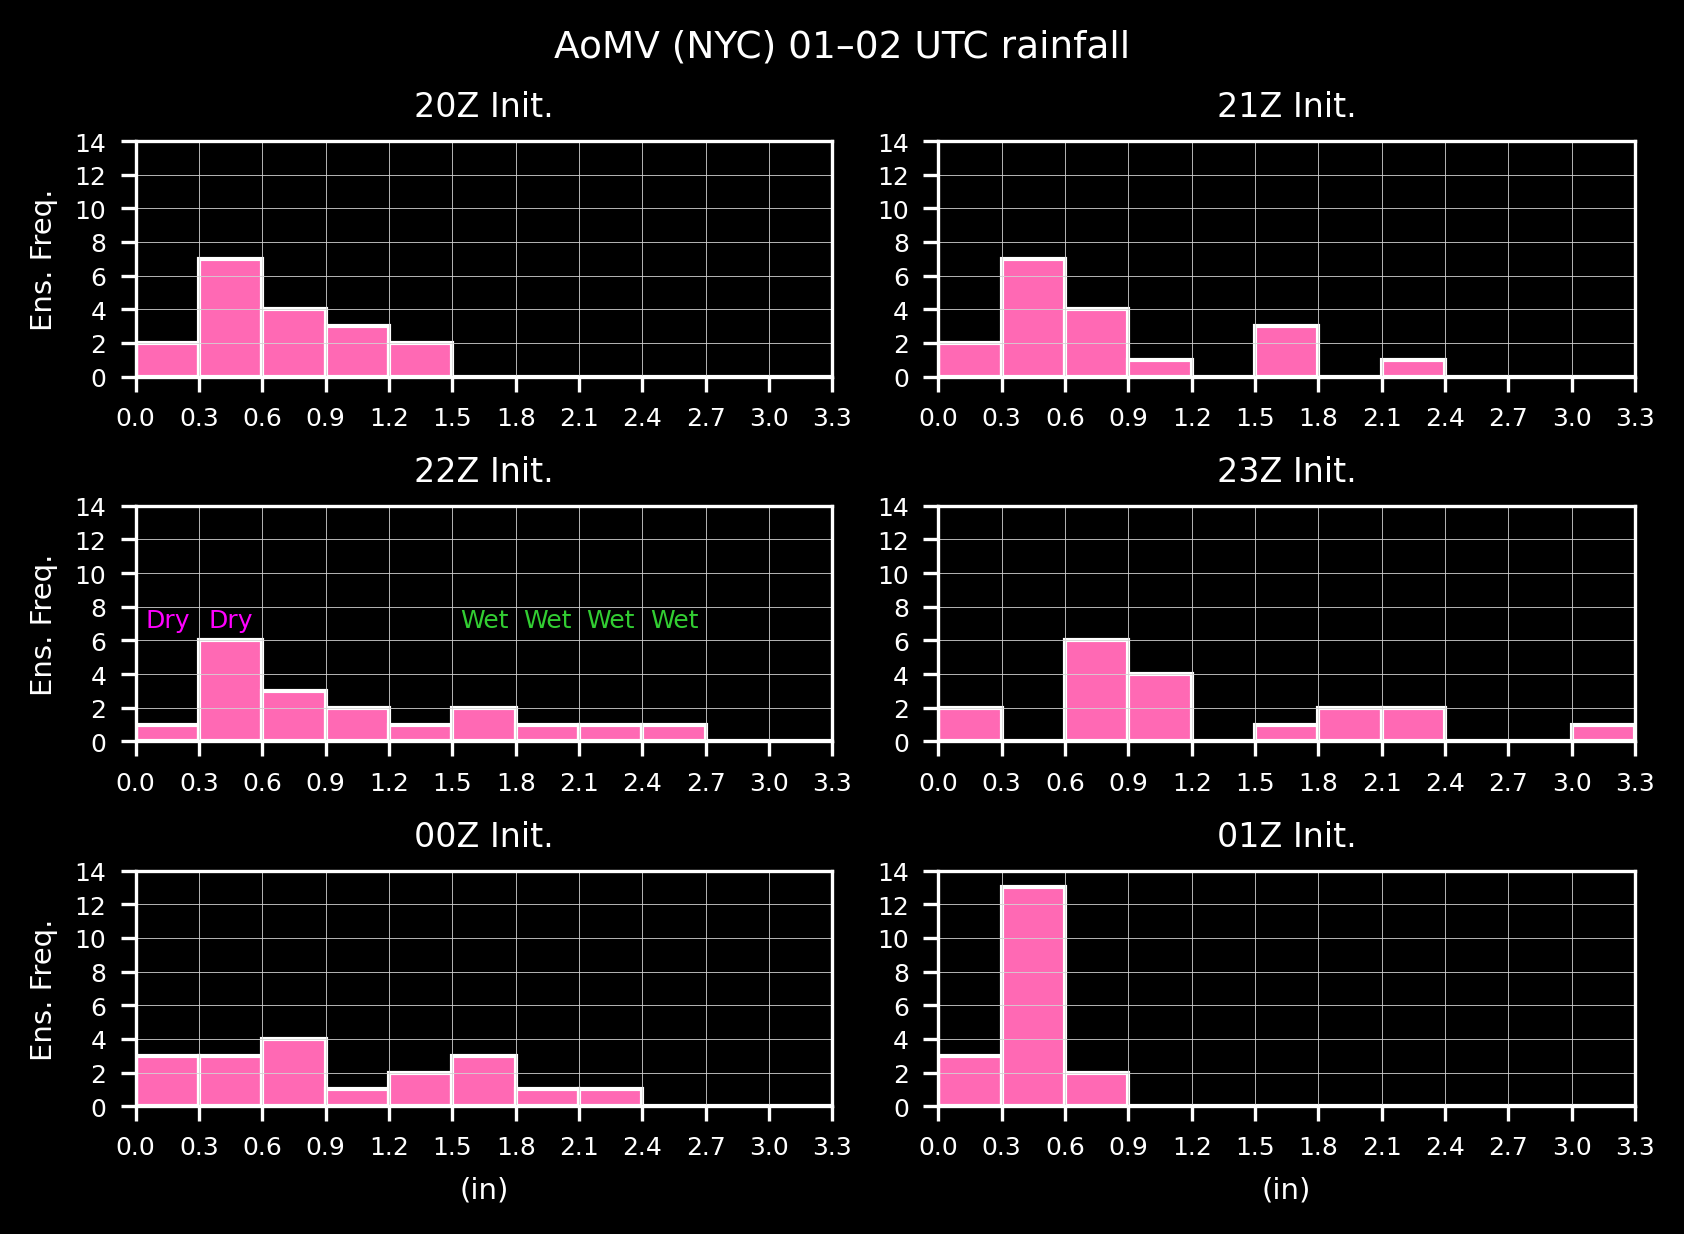

In [6]:
# bins = np.histogram_bin_edges(
#     np.concat([rain12_aoi.values]), bins="auto"
# )
bins = np.arange(0,3.4,0.3)

# Make a list of titles
titles = ["20Z Init.", "21Z Init.", "22Z Init.", "23Z Init.", "00Z Init.", "01Z Init."]

# # Function to format the x-tick labels to two decimal points
# def two_decimal_formatter(x, pos):
#     return f"{x:.1f}"

# Make a 3 x 2 figure with a histogram of 1-2 UTC rainfall for each initialization
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    sharex=True,
    sharey=True,
    dpi=300,
    figsize=(5.5, 4),
    layout="constrained",
)

# Width for the bars in the histograms
bar_width = (bins[1] - bins[0]) / 1

# Loop through each initialization
for i, ax in enumerate(axes.flatten()):
    # Extract the data for the current initialization
    new_data = rain12_aoi.isel(init=i).values

    # Compute the histogram
    new_hist, _ = np.histogram(new_data, bins=bins)

    bars = ax.bar(
        bins[:-1],
        new_hist,
        width=bar_width,
        align="edge",
        edgecolor="white",
        color="hotpink",
        label="New WoFS",
    )

    # Highlight specified bins in the middle left plot
    if i == 2:  # Middle left plot
        wet_bins = [(1.8, 2.1), (1.5, 1.8), (2.1,2.4), (2.4,2.7)]
        dry_bins = [(0, 0.3), (0.3, 0.6)]
        
        for wet_bin in wet_bins:
            ax.text(
                (wet_bin[0] + wet_bin[1]) / 2,
                max(new_hist) + 0.5,
                'Wet',
                color='limegreen',
                ha='center',
                va='bottom',
                fontsize=6
            )

        for dry_bin in dry_bins:
            ax.text(
                (dry_bin[0] + dry_bin[1]) / 2,
                max(new_hist) + 0.5,
                'Dry',
                color='magenta',
                ha='center',
                va='bottom',
                fontsize=6
            )

    ax.xaxis.set_tick_params(which="both", labelbottom=True)
    ax.tick_params(axis="both", labelsize=6)
    ax.set_xticks(bins)
    ax.set_yticks(range(0, 15, 2))
    ax.yaxis.set_tick_params(which="both", labelleft=True)
    ax.grid(color="lightgray", linewidth=0.2)
    ax.set_title(titles[i], fontsize=8)
    ax.set_xlabel("")

    # # Set the x-axis formatter to round to two decimal points
    # ax.xaxis.set_major_formatter(FuncFormatter(two_decimal_formatter))

    if i % 2 == 0:
        ax.set_ylabel("Ens. Freq.", fontsize=7)

# Set the x-axis labels for the bottom row of plots
axes[2, 1].set_xlabel("(in)", fontsize=7)
axes[2, 0].set_xlabel("(in)", fontsize=7)

# Set the x-axis limit
plt.xlim(bins.min(), bins.max())

# Set the overall title of the figure
plt.suptitle("AoMV (NYC) 01–02 UTC rainfall", fontsize=9)

# Show the plot
plt.show()